In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon

import geoplot
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('US_Accidents_March23_sampled_500k.csv')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [3]:
print("Shape: ",df.shape[0],",",df.shape[1])
df.isnull().sum()

Shape:  500000 , 46


ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  220377
End_Lng                  220377
Distance(mi)                  0
Description                   1
Street                      691
City                         19
County                        0
State                         0
Zipcode                     116
Country                       0
Timezone                    507
Airport_Code               1446
Weather_Timestamp          7674
Temperature(F)            10466
Wind_Chill(F)            129017
Humidity(%)               11130
Pressure(in)               8928
Visibility(mi)            11291
Wind_Direction            11197
Wind_Speed(mph)           36987
Precipitation(in)        142616
Weather_Condition         11101
Amenity                       0
Bump                          0
Crossing

In [4]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'].str[:19], format='%Y-%m-%d %H:%M:%S')
df['End_Time'] = pd.to_datetime(df['End_Time'].str[:19], format='%Y-%m-%d %H:%M:%S')

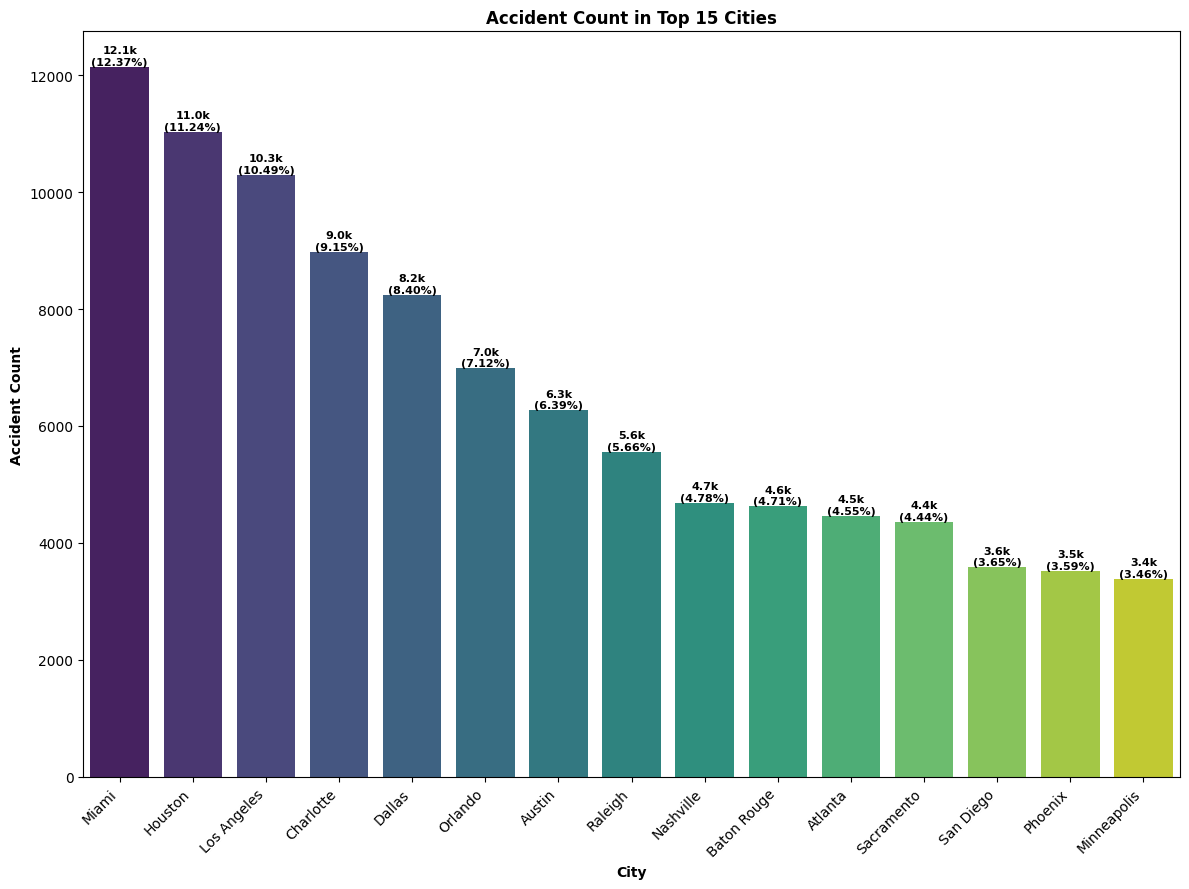

In [5]:
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={'index':'City'})
top_15_cities = pd.DataFrame(city_df.head(15))
total_accidents = top_15_cities['count'].sum()
plt.figure(figsize=(12, 9))
sns.barplot(x='City', y='count', data=top_15_cities, palette='viridis')
for index, value in enumerate(top_15_cities['count']):
    percent = (value / total_accidents) * 100
    rounded_value = round(value / 1000, 1)  # Round to one decimal place and convert to thousands
    plt.text(index, value + 1, f'{rounded_value}k\n({percent:.2f}%)', ha='center', va='bottom', fontsize=8, color='black', fontweight='bold')

plt.title('Accident Count in Top 15 Cities', fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Accident Count', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
states = gpd.read_file('../input/us-states-map')

def lat(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    return (location.latitude)

def lng(city):
    address=city
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    return (location.longitude)

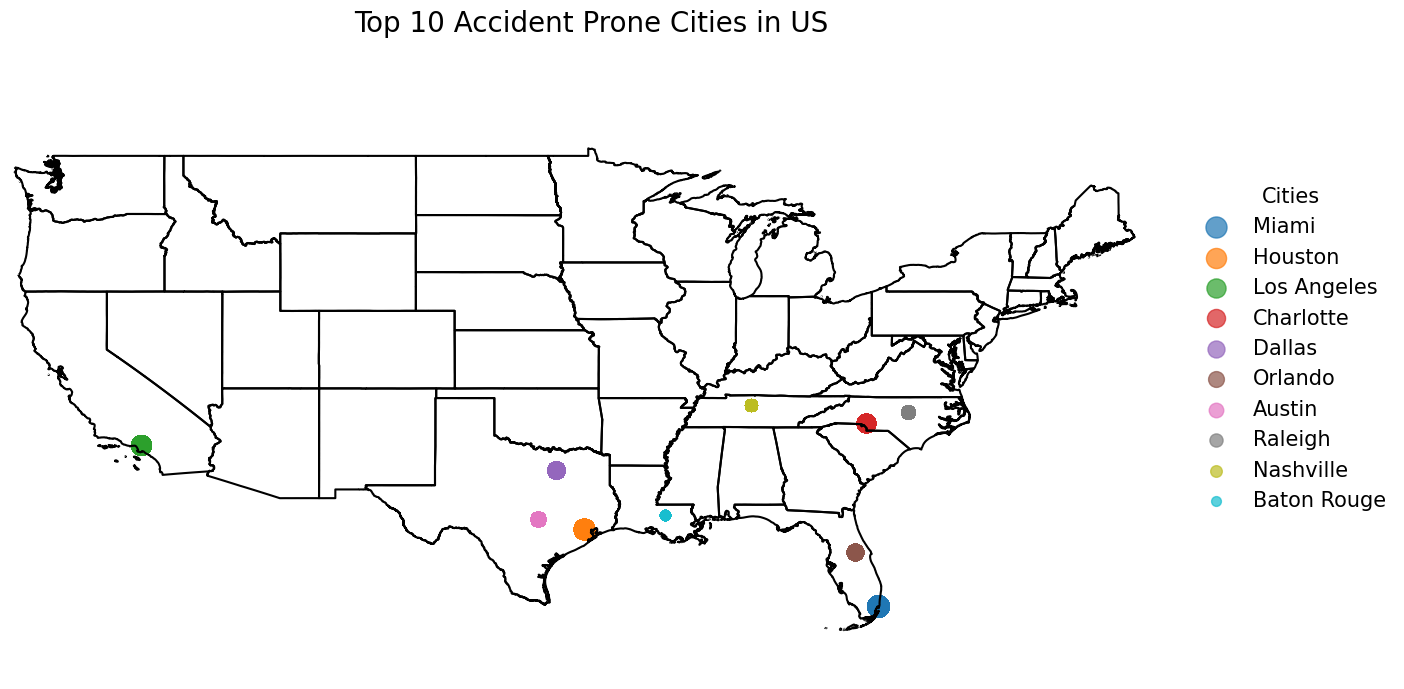

In [7]:
top_cities = pd.DataFrame(city_df.head(10))
top_city_list = list(city_df.City.head(10))
top_city_lat_dict = {}
top_city_lng_dict = {}
for i in top_city_list:
    top_city_lat_dict[i] = lat(i)
    top_city_lng_dict[i] = lng(i)
top_cities_df = df[df['City'].isin(list(top_cities.City))]

top_cities_df.loc[:, 'City_Lat'] = top_cities_df['City'].map(top_city_lat_dict)
top_cities_df.loc[:, 'City_Lng'] = top_cities_df['City'].map(top_city_lng_dict)

geometry_cities = [Point(xy) for xy in zip(top_cities_df['City_Lng'], top_cities_df['City_Lat'])]
geo_df_cities = gpd.GeoDataFrame(top_cities_df, geometry=geometry_cities)

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states.boundary.plot(ax=ax, color='black');

markersizes = [50+(i*20) for i in range(len(top_city_list))][::-1]
for i in range(len(top_city_list)):
    geo_df_cities[geo_df_cities['City'] == top_city_list[i]].plot(ax=ax, markersize=markersizes[i], marker='o', 
                                                                      label=top_city_list[i], alpha=0.7);
    
plt.legend(prop={'size': 15}, loc='best', bbox_to_anchor=(.60, 0., 0.6, 0.80), edgecolor='white', title="Cities", title_fontsize=15);

for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title(f'Top {len(top_city_list)} Accident Prone Cities in US', size=20, color='black');

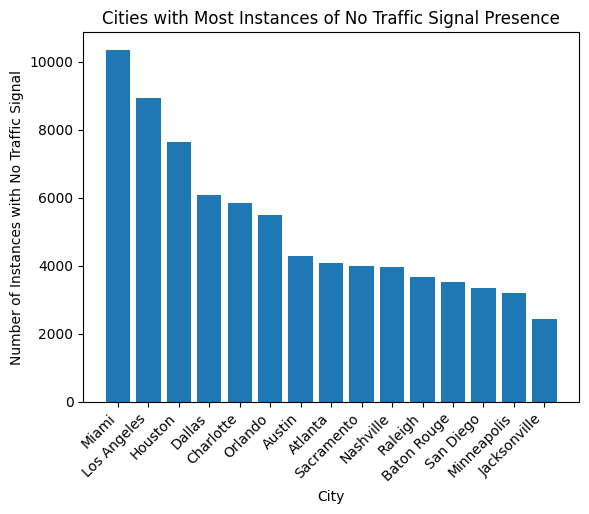

In [8]:
cities_with_no_traffic_signal = df[df['Traffic_Signal'] == False]['City'].value_counts().head(15)
plt.bar(cities_with_no_traffic_signal.index, cities_with_no_traffic_signal.values)
plt.xlabel('City')
plt.ylabel('Number of Instances with No Traffic Signal')
plt.title('Cities with Most Instances of No Traffic Signal Presence')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

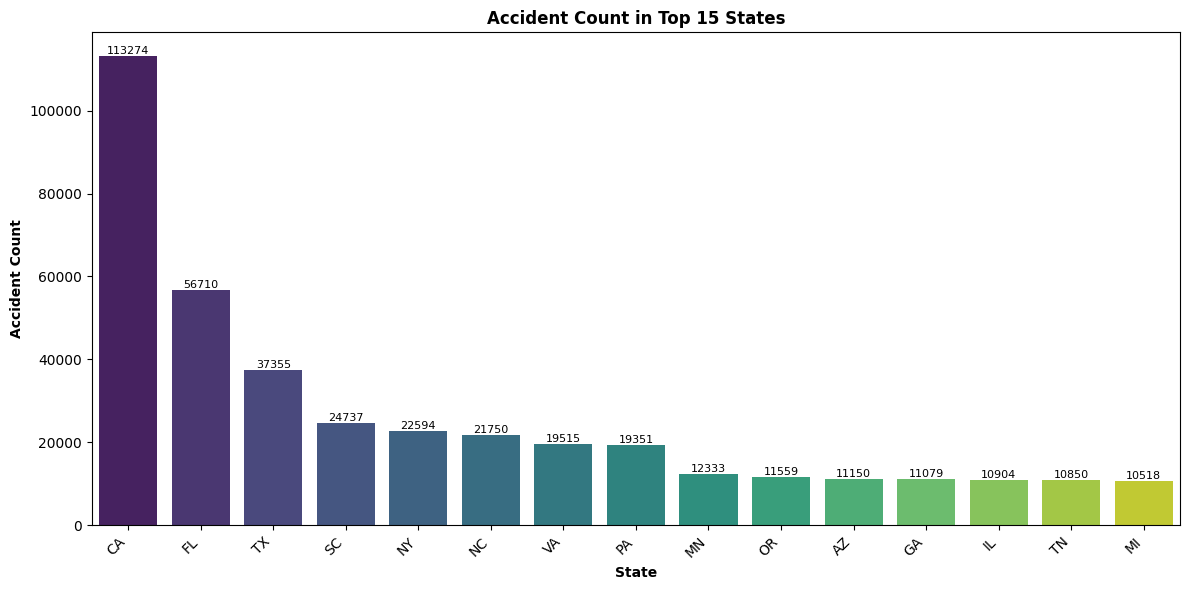

In [9]:
State_df = pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'State'})
top_15_states = pd.DataFrame(State_df.head(15))
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='count', data=top_15_states, palette='viridis')
for index, value in enumerate(top_15_states['count']):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=8, color='black')
plt.title('Accident Count in Top 15 States', fontweight='bold')
plt.xlabel('State', fontweight='bold')
plt.ylabel('Accident Count', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
State_city = df.groupby(['State', 'City']).size().groupby('State').idxmax()
result = pd.DataFrame(State_city.tolist(), columns=['State', 'City'])
result['Count'] = df.groupby(['State', 'City']).size().groupby('State').max().tolist()

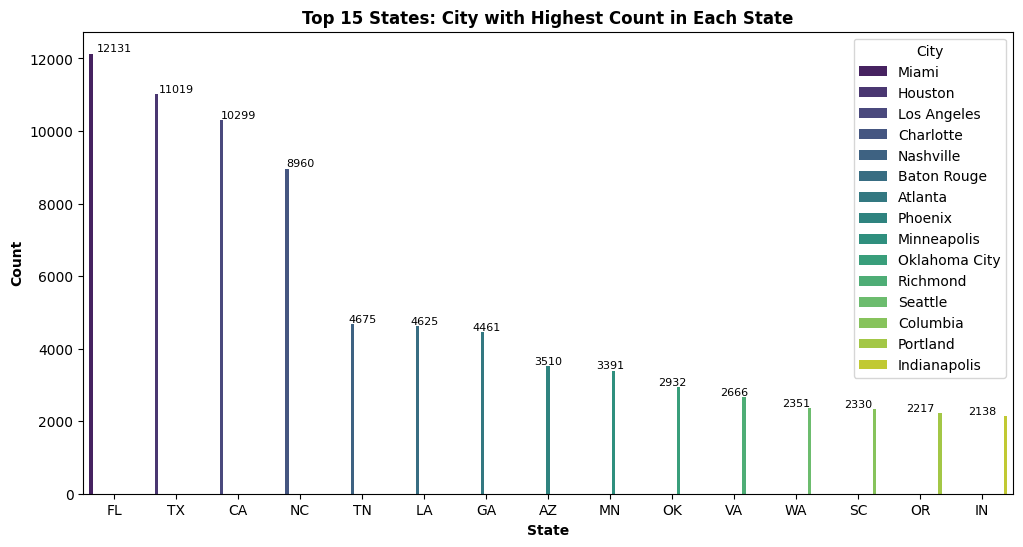

In [11]:
top_15_states_city = result.sort_values(by='Count', ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Count', hue='City', data=top_15_states_city, palette='viridis')
for index, value in enumerate(top_15_states_city['Count']):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=8, color='black')
plt.title('Top 15 States: City with Highest Count in Each State', fontweight='bold')
plt.xlabel('State', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend(title='City', loc='upper right')
plt.show()

In [12]:
city_street = df.groupby(['City', 'Street']).size().groupby('City').idxmax()
result = pd.DataFrame(city_street.tolist(), columns=['City', 'Street'])
result['Count'] = df.groupby(['City', 'Street']).size().groupby('City').max().values.tolist()

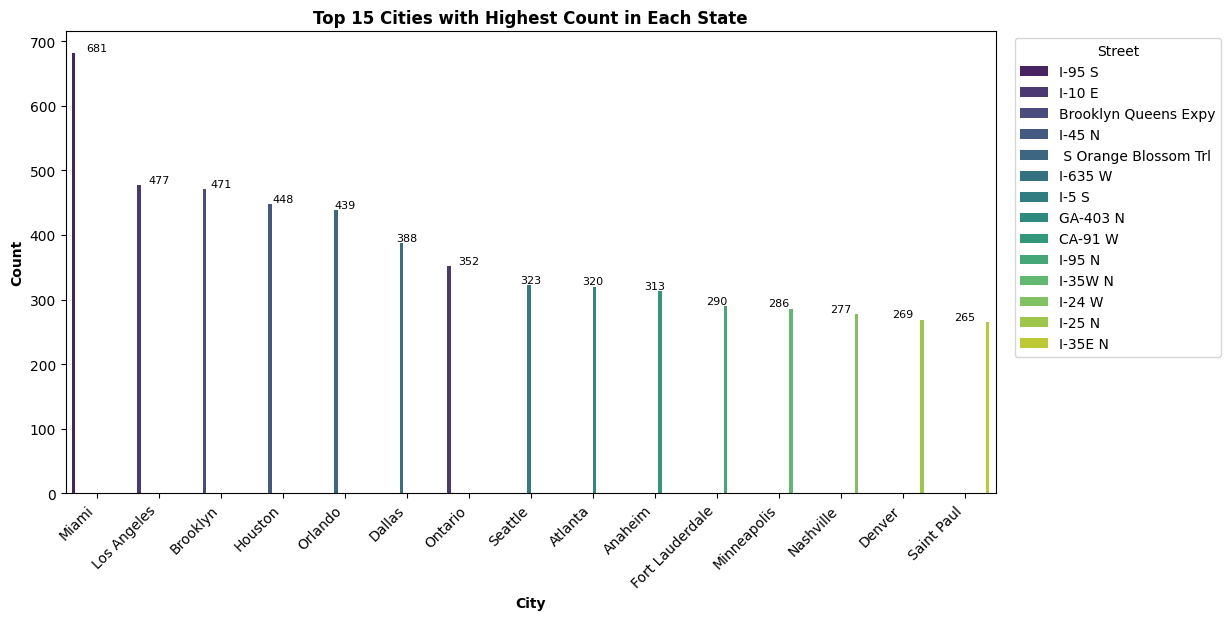

In [13]:
top_15_city_street = result.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='City', y='Count', hue='Street', data=top_15_city_street, palette='viridis')

for index, value in enumerate(top_15_city_street['Count']):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=8, color='black')

plt.title('Top 15 Cities with Highest Count in Each State', fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend(title='Street', bbox_to_anchor=(1.25, 1), loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

In [14]:
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

geo_df['year'] = geo_df.Start_Time.dt.year

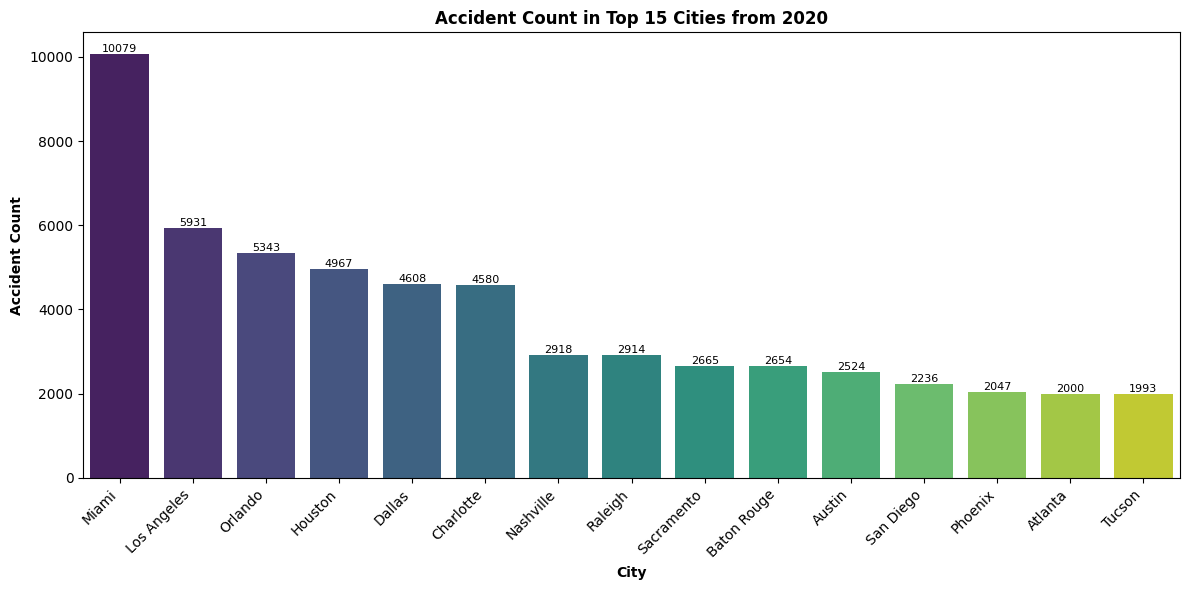

In [15]:
yr=2020
df_yr = geo_df[geo_df['year'] >= yr]
city_df_yr = pd.DataFrame(df_yr['City'].value_counts()).reset_index().rename(columns={'index':'City'})
top_15_cities = pd.DataFrame(city_df_yr.head(15))
plt.figure(figsize=(12, 6))
sns.barplot(x='City', y='count', data=top_15_cities, palette='viridis')
for index, value in enumerate(top_15_cities['count']):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=8, color='black')

plt.title(f'Accident Count in Top 15 Cities from {yr}', fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Accident Count', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

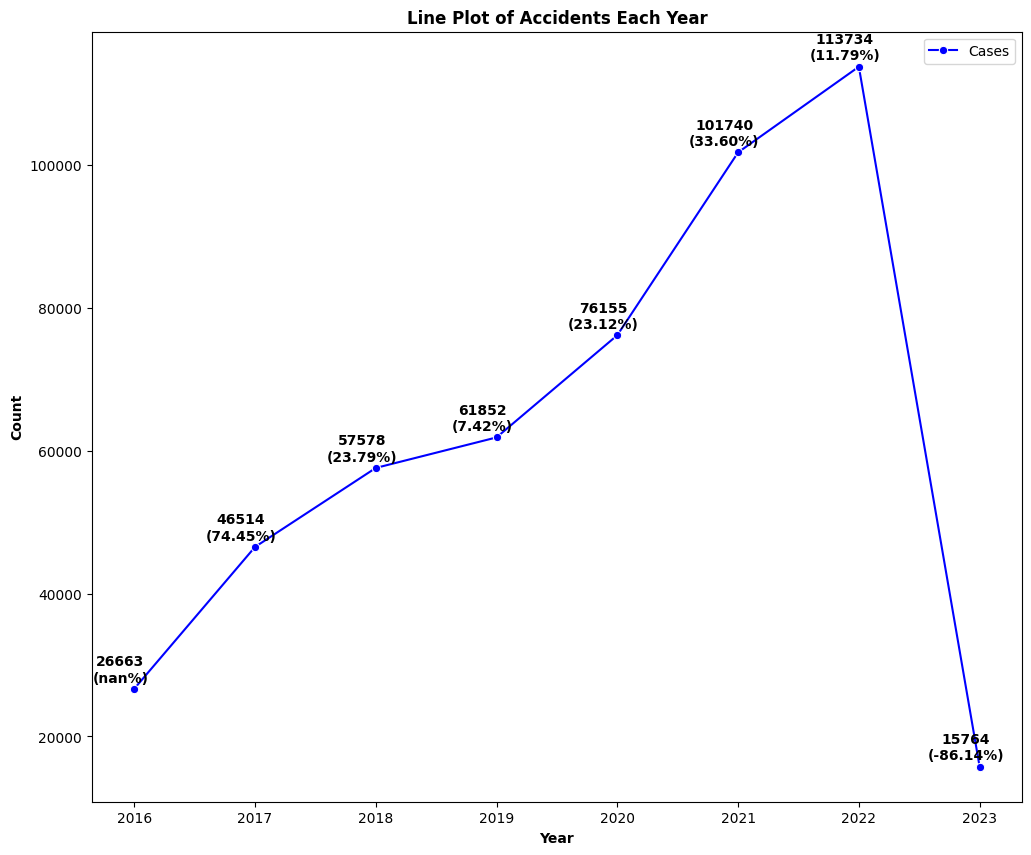

In [16]:
year_df = pd.DataFrame(df.Start_Time.dt.year.value_counts()).reset_index().rename(columns={'index':'Year', 'Start_Time':'Case_yr', 'count':'Cases'}).sort_values(by='Case_yr', ascending=True)
year_df['Growth'] = year_df['Cases'].pct_change() * 100
plt.figure(figsize=(12, 10))
sns.lineplot(x='Case_yr', y='Cases', data=year_df, marker='o', color='b', label='Cases')
for i, (cases, growth) in enumerate(zip(year_df['Cases'], year_df['Growth'])):
    plt.annotate(f"{cases}\n({growth:.2f}%)", (year_df['Case_yr'].iloc[i], cases), textcoords="offset points", xytext=(-10, 5), ha='center', fontsize=10, weight='bold')
plt.title('Line Plot of Accidents Each Year', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.legend()
plt.show()

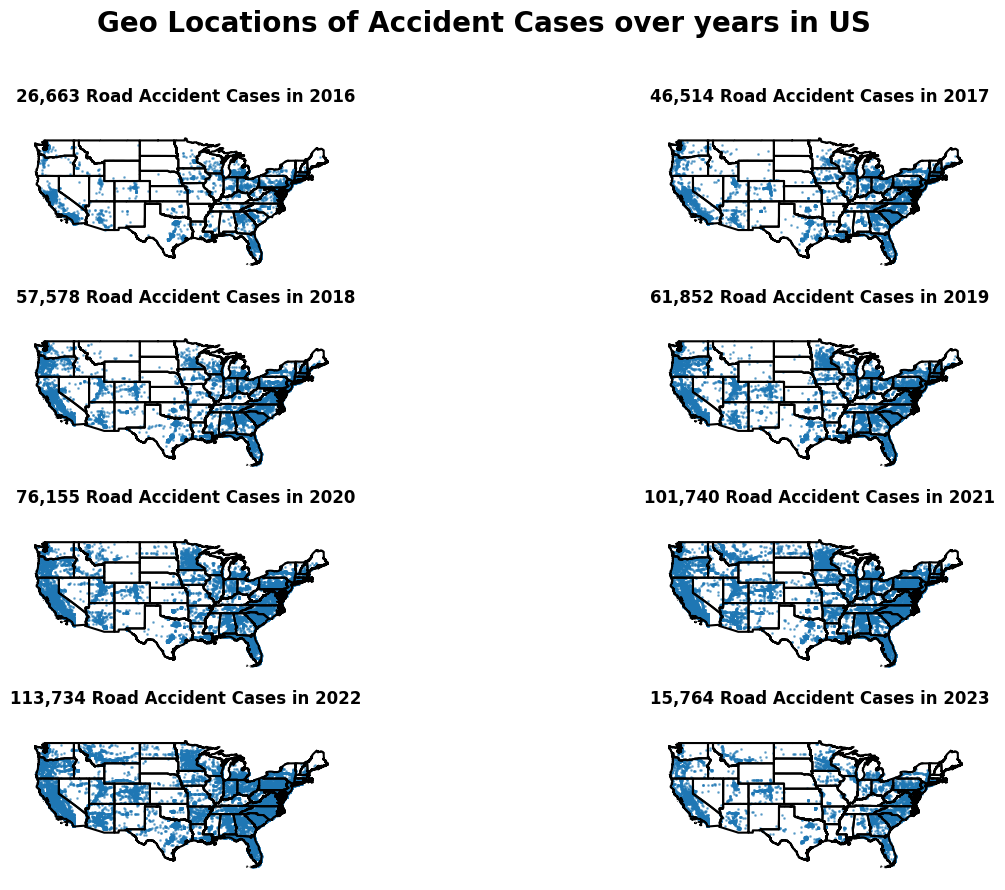

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
fig.suptitle('Geo Locations of Accident Cases over years in US', fontsize=20,fontweight ="bold", color='black')
count = 0
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
for i in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    i.set_xlim([-125,-65])
    i.set_ylim([22,55])
    states.boundary.plot(ax=i, color='black');
    geo_df[geo_df['year']==int(years[count])].plot(ax=i, markersize=1, marker='o', alpha=0.5)
    for j in ['bottom', 'top', 'left', 'right']:
        side = i.spines[j]
        side.set_visible(False)
    i.set_title('{:,} Road Accident Cases in {}'.format(list(year_df.Cases)[count], years[count]), fontsize=12, color='black', weight='bold')
    i.axis('off')
    count += 1
    


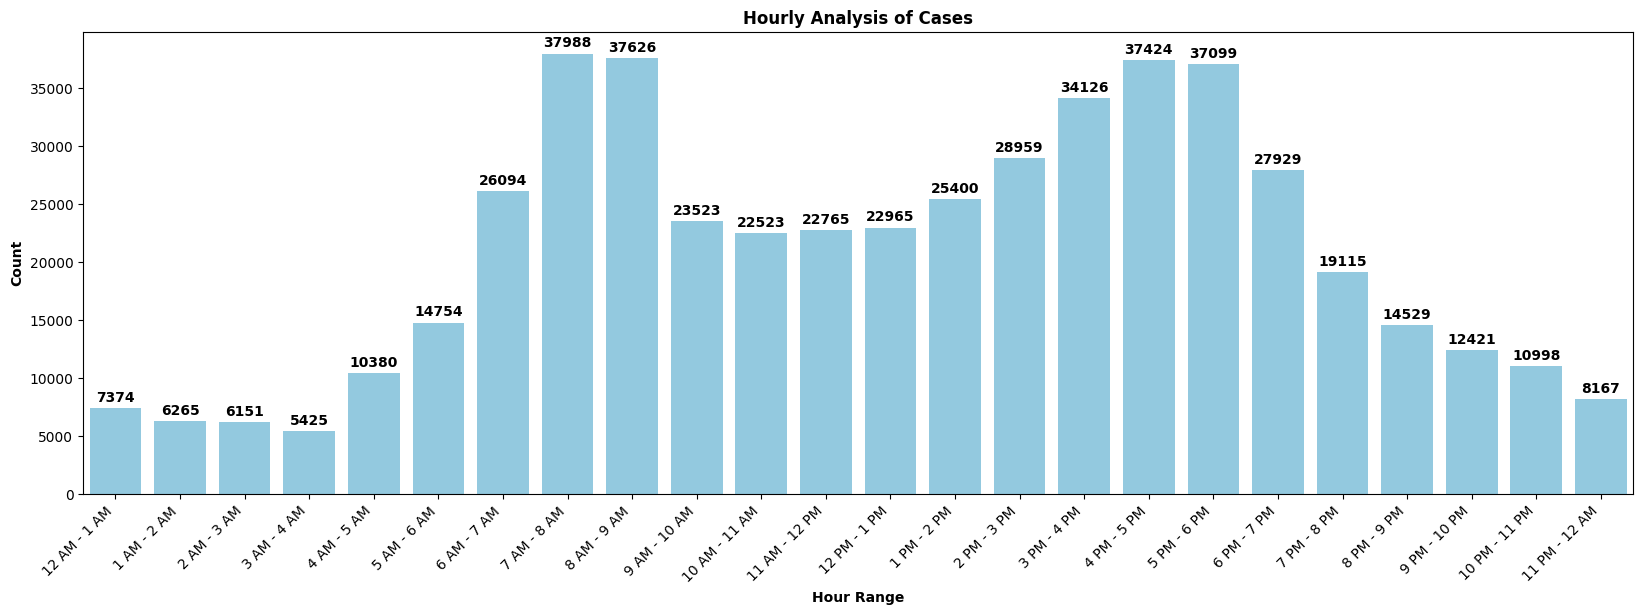

In [18]:
hour_df = pd.DataFrame(df.Start_Time.dt.hour.value_counts()).reset_index().rename(columns={'index':'Hours', 'Start_Time':'Hr', 'count':'Cases'}).sort_values('Hr')
hour_mapping = {0: '12 AM - 1 AM', 1: '1 AM - 2 AM', 2: '2 AM - 3 AM', 3: '3 AM - 4 AM', 4: '4 AM - 5 AM',
                5: '5 AM - 6 AM', 6: '6 AM - 7 AM', 7: '7 AM - 8 AM', 8: '8 AM - 9 AM', 9: '9 AM - 10 AM',
                10: '10 AM - 11 AM', 11: '11 AM - 12 PM', 12: '12 PM - 1 PM', 13: '1 PM - 2 PM', 14: '2 PM - 3 PM',
                15: '3 PM - 4 PM', 16: '4 PM - 5 PM', 17: '5 PM - 6 PM', 18: '6 PM - 7 PM', 19: '7 PM - 8 PM',
                20: '8 PM - 9 PM', 21: '9 PM - 10 PM', 22: '10 PM - 11 PM', 23: '11 PM - 12 AM'}

hour_df['Hour_Range'] = hour_df['Hr'].map(hour_mapping)

plt.figure(figsize=(20, 6))
sns.barplot(x='Hour_Range', y='Cases', data=hour_df, color='skyblue')

for i, txt in enumerate(hour_df['Cases']):
    plt.annotate(f"{txt}", (i, txt), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, weight='bold')

plt.title('Hourly Analysis of Cases', fontweight='bold')
plt.xlabel('Hour Range', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.show()

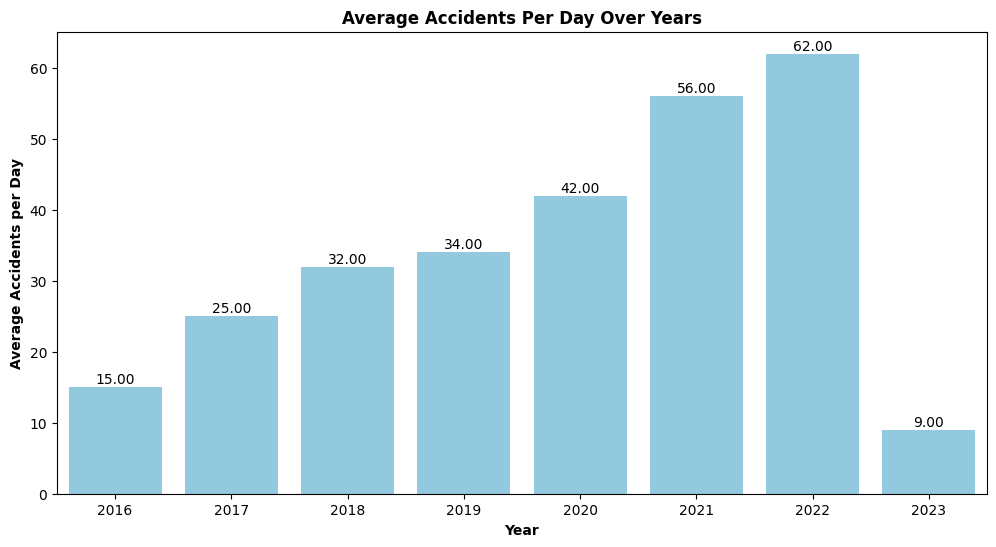

In [19]:
year_df['accident/day'] = round(year_df['Cases']/(5*365))
year_df['accident/hour'] = round(year_df['Cases']/(5*365*24))
plt.figure(figsize=(12, 6))
sns.barplot(x=year_df['Case_yr'], y=year_df['accident/day'], color='skyblue', label='Accidents per Day')
for i, value in enumerate(year_df['accident/day']):
    plt.text(i, value + 0.1, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='black')

plt.title('Average Accidents Per Day Over Years', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Accidents per Day', fontweight='bold')

plt.show()

In [20]:
year_df

,Case_yr,Cases,Growth,accident/day,accident/hour
6,2016,26663,NaN,15.0,1.0
5,2017,46514,74.451487,25.0,1.0
4,2018,57578,23.786387,32.0,1.0
3,2019,61852,7.422974,34.0,1.0
2,2020,76155,23.124555,42.0,2.0
1,2021,101740,33.595956,56.0,2.0
0,2022,113734,11.788874,62.0,3.0
7,2023,15764,-86.139589,9.0,0.0


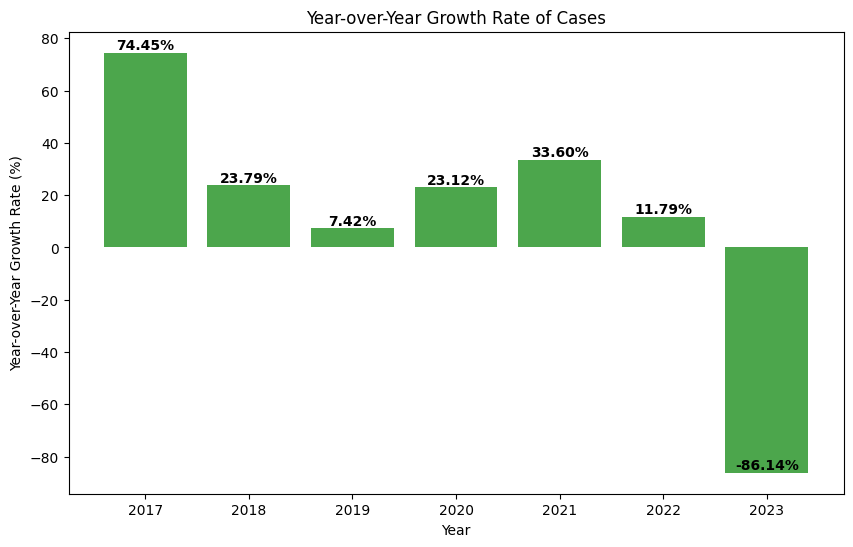

In [21]:
year_df['YoY_Growth'] = year_df['Cases'].pct_change() * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(year_df.Case_yr, year_df['YoY_Growth'], color='green', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Year')
plt.ylabel('Year-over-Year Growth Rate (%)')
plt.title('Year-over-Year Growth Rate of Cases')
plt.show()


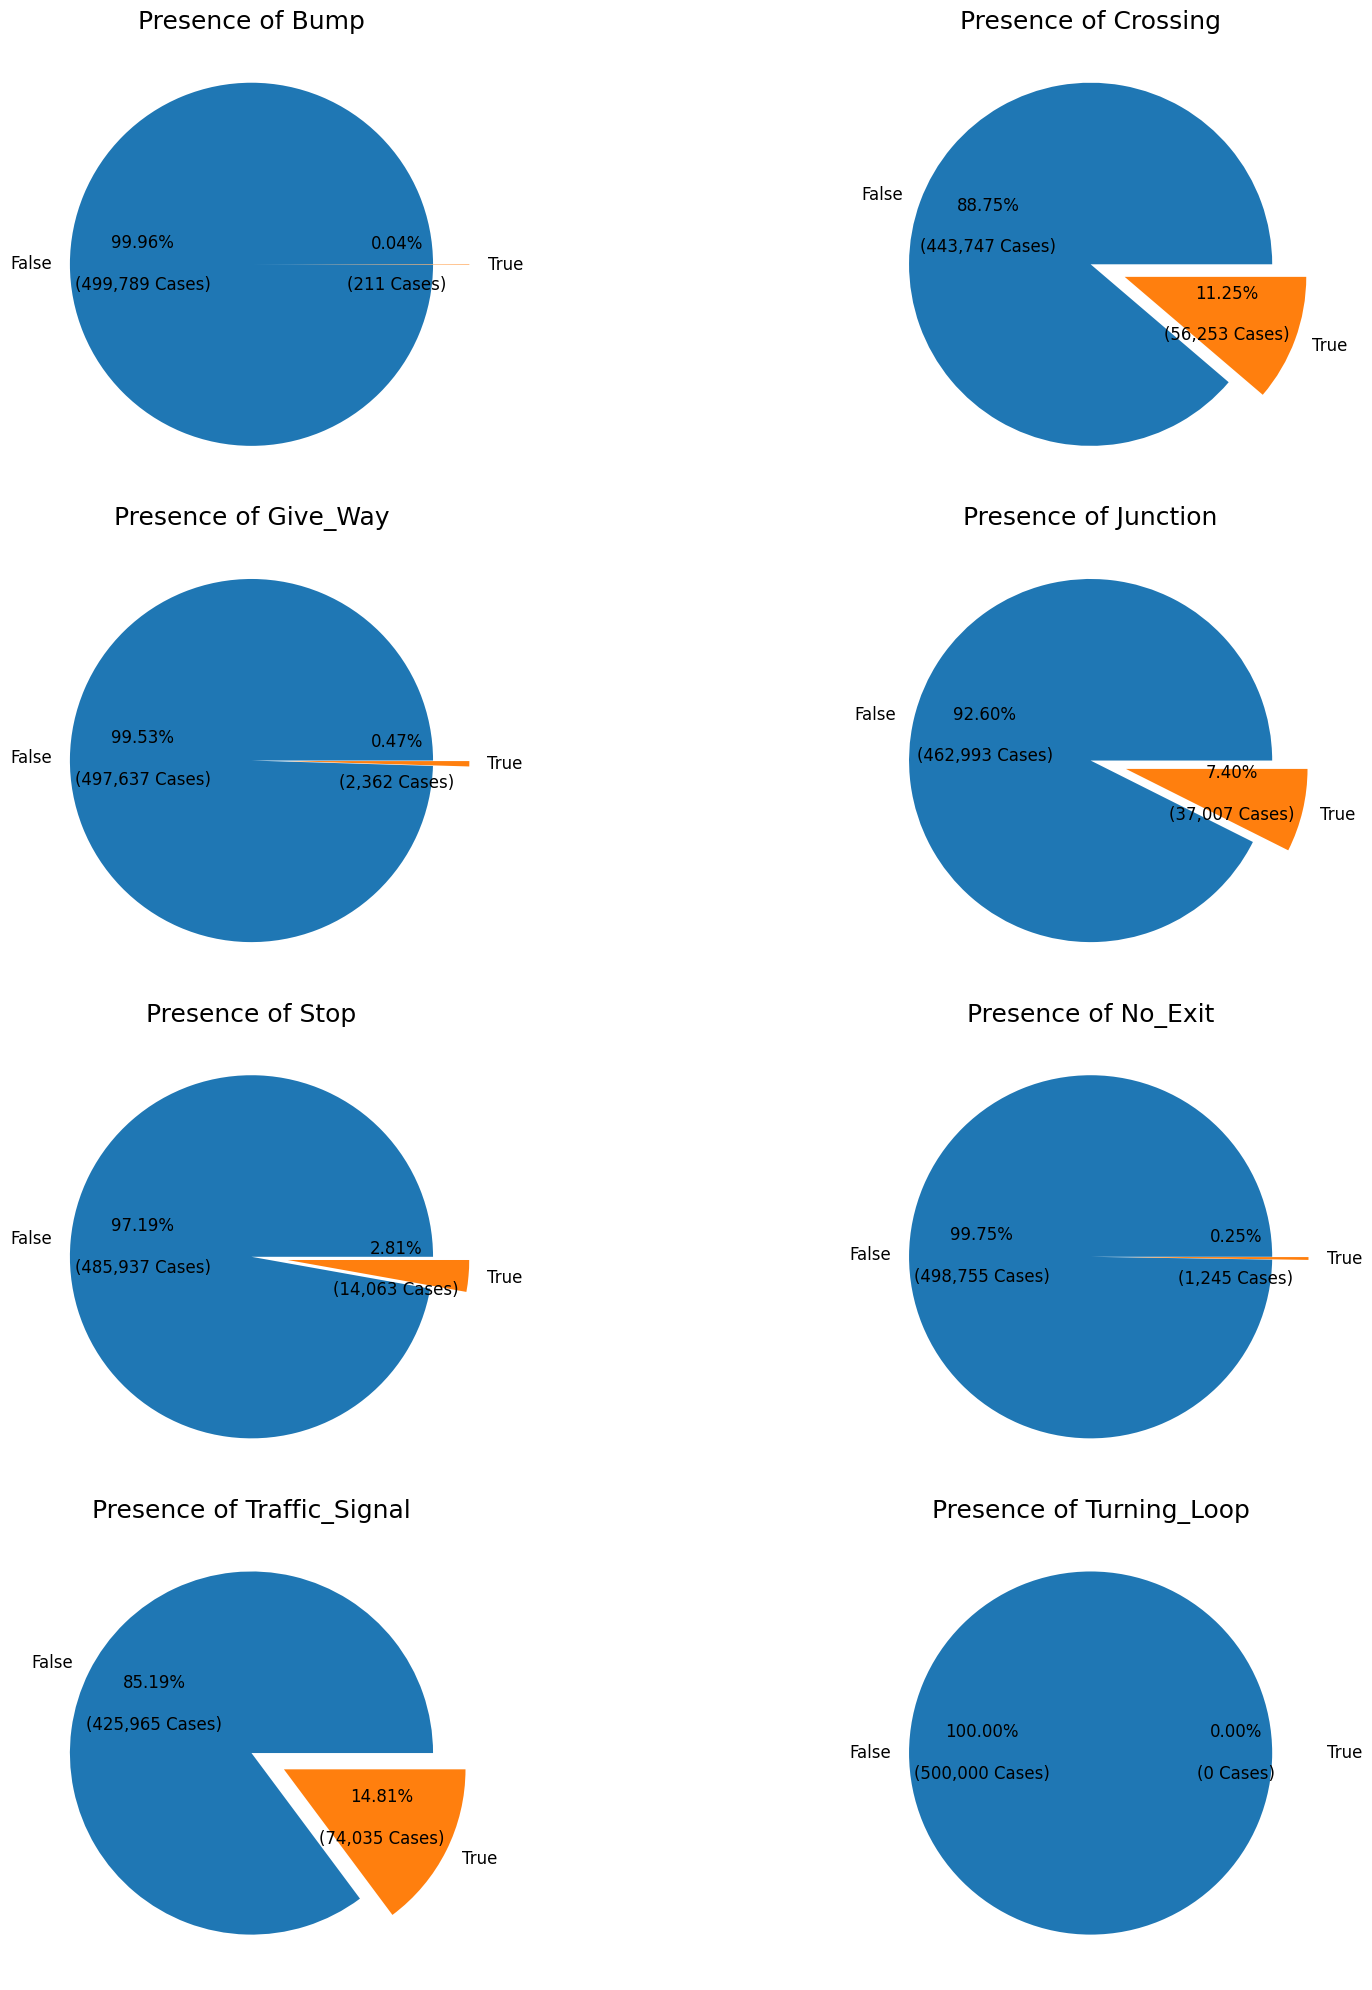

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

road_conditions = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'Stop', 'No_Exit', 'Traffic_Signal', 'Turning_Loop']

def func(pct, allvals):
    absolute = int(round(pct / 100 * np.sum(allvals), 2))
    return "{:.2f}%\n\n({:,d} Cases)".format(pct, absolute)

for ax, condition in zip(axes.flatten(), road_conditions):
    size = list(df[condition].value_counts())
    size.extend([0] * (2 - len(size)))  
    labels = ['False', 'True']
    
    ax.pie(size, labels=labels, autopct=lambda pct: func(pct, size), labeldistance=1.1, textprops={'fontsize': 12}, explode=[0, 0.2])

    title = 'Presence of {}'.format(condition)
    ax.set_title(title, fontsize=18, color='black')

plt.tight_layout()
plt.show()

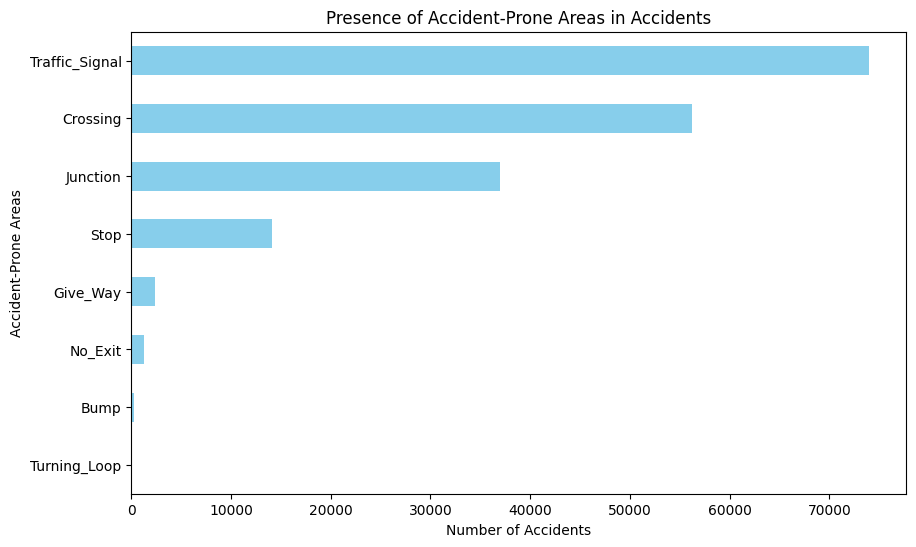

In [23]:
presence_columns = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'Stop', 'No_Exit', 'Traffic_Signal', 'Turning_Loop']

presence_counts = df[presence_columns].sum()

plt.figure(figsize=(10, 6))
presence_counts.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Number of Accidents')
plt.ylabel('Accident-Prone Areas')
plt.title('Presence of Accident-Prone Areas in Accidents')
plt.show()

In [24]:
severity_df = pd.DataFrame(df['Severity'].value_counts()).reset_index()
severity_df.columns = ['Severity', 'Cases']

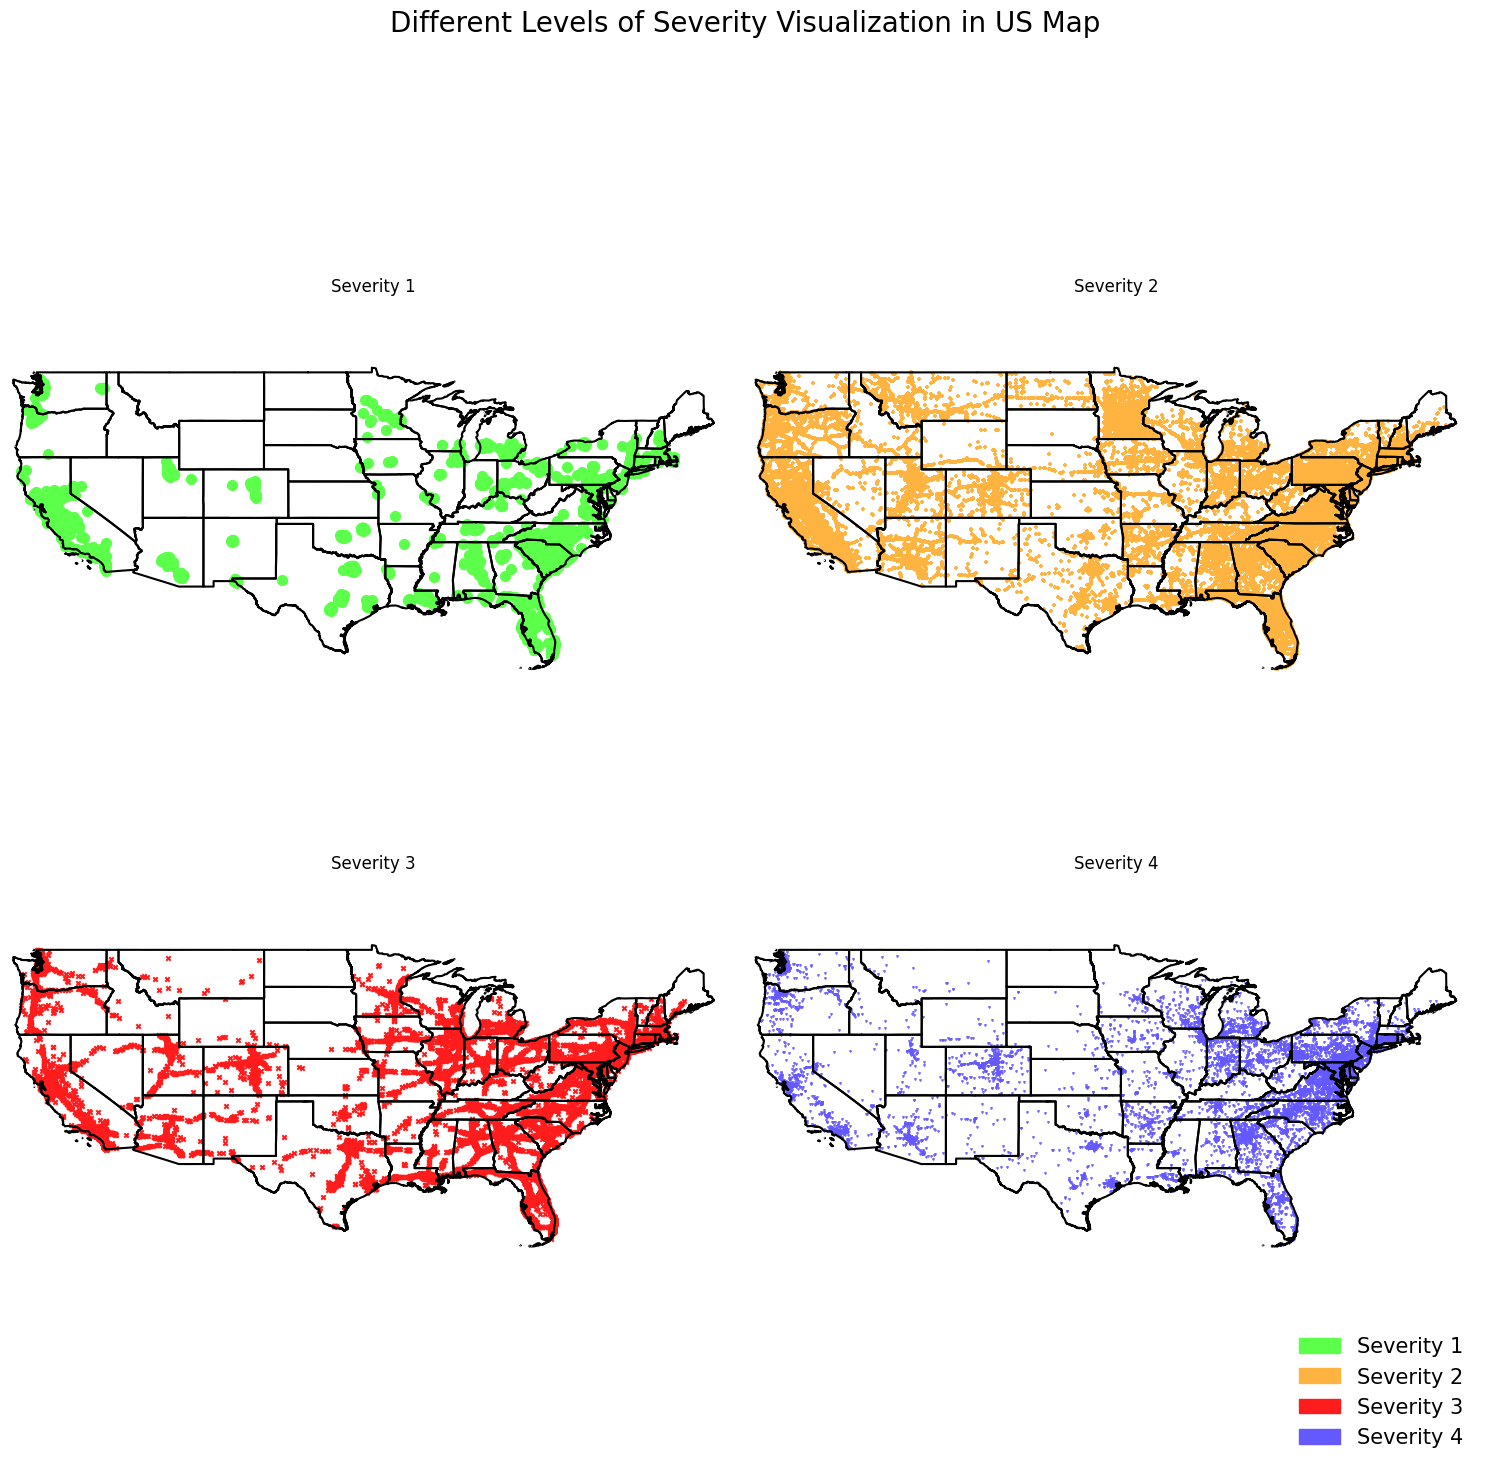

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Different Levels of Severity Visualization in US Map', size=20, color='black')

for ax in axs.flat:
    ax.set_xlim([-125, -65])
    ax.set_ylim([22, 55])
    states.boundary.plot(ax=ax, color='black')  # Add this line to draw the state boundaries

geo_df[geo_df['Severity'] == 1].plot(ax=axs[0, 0], markersize=50, color='#5cff4a', marker='o', label='Severity 1')
axs[0, 0].set_title('Severity 1')

geo_df[geo_df['Severity'] == 2].plot(ax=axs[0, 1], markersize=5, color='#ffb340', marker='+', label='Severity 2')
axs[0, 1].set_title('Severity 2')

geo_df[geo_df['Severity'] == 3].plot(ax=axs[1, 0], markersize=10, color='#ff1c1c', marker='x', label='Severity 3')
axs[1, 0].set_title('Severity 3')

geo_df[geo_df['Severity'] == 4].plot(ax=axs[1, 1], markersize=1, color='#6459ff', marker='v', label='Severity 4')
axs[1, 1].set_title('Severity 4')

for ax in axs.flat:
    for i in ['bottom', 'top', 'left', 'right']:
        side = ax.spines[i]
        side.set_visible(False)
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

One = mpatches.Patch(color='#5cff4a', label='Severity 1')
Two = mpatches.Patch(color='#ffb340', label='Severity 2')
Three = mpatches.Patch(color='#ff1c1c', label='Severity 3')
Four = mpatches.Patch(color='#6459ff', label='Severity 4')

fig.legend(handles=[One, Two, Three, Four], prop={'size': 15}, loc='lower right', borderpad=1, edgecolor='white')

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()



Year: 2016
Severity 1: 0.07%
Severity 2: 65.91%
Severity 3: 30.72%
Severity 4: 3.30%

Year: 2017
Severity 1: 0.04%
Severity 2: 64.18%
Severity 3: 32.45%
Severity 4: 3.34%

Year: 2018
Severity 1: 0.02%
Severity 2: 64.42%
Severity 3: 32.76%
Severity 4: 2.80%

Year: 2019
Severity 1: 0.03%
Severity 2: 71.91%
Severity 3: 25.09%
Severity 4: 2.97%

Year: 2020
Severity 1: 2.37%
Severity 2: 79.14%
Severity 3: 15.84%
Severity 4: 2.65%

Year: 2021
Severity 1: 0.01%
Severity 2: 88.56%
Severity 3: 9.53%
Severity 4: 1.91%

Year: 2022
Severity 1: 2.11%
Severity 2: 90.99%
Severity 3: 4.49%
Severity 4: 2.42%

Year: 2023
Severity 1: 0.00%
Severity 2: 96.99%
Severity 3: 0.00%
Severity 4: 3.01%


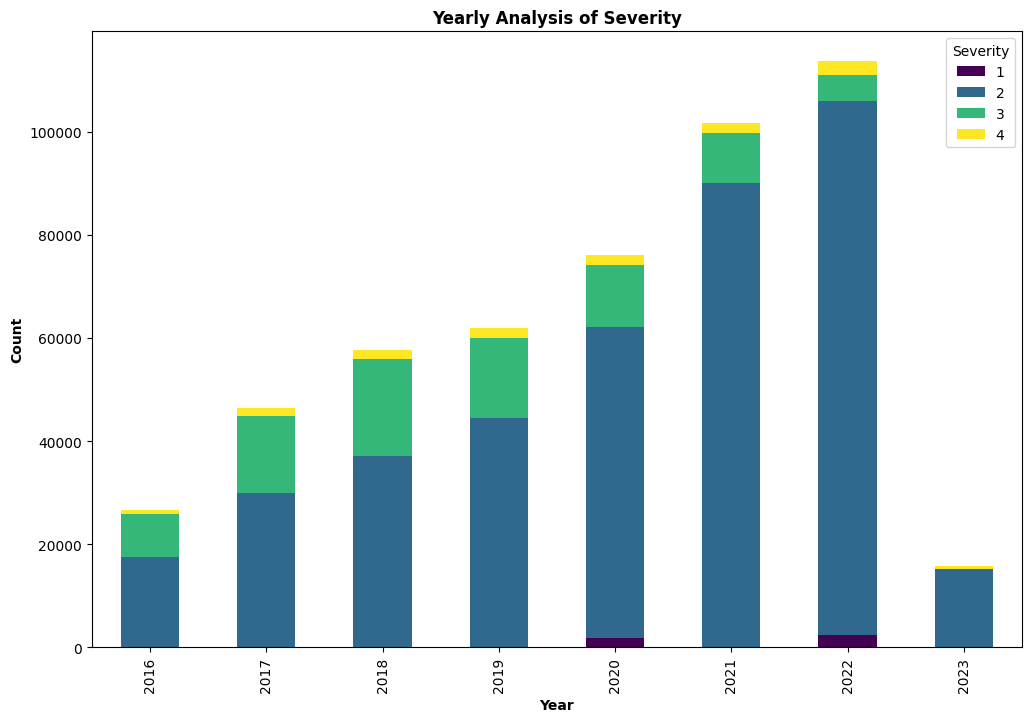

In [26]:
yearly_analysis = geo_df.groupby(['year', 'Severity']).size().unstack(fill_value=0)

yearly_percentage = yearly_analysis.div(yearly_analysis.sum(axis=1), axis=0) * 100

for year, row in yearly_percentage.iterrows():
    print(f'\nYear: {year}')
    for severity, percentage in row.items():
        print(f'Severity {severity}: {percentage:.2f}%')

ax = yearly_analysis.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Yearly Analysis of Severity', fontweight='bold')

ax.legend(title='Severity')

plt.show()

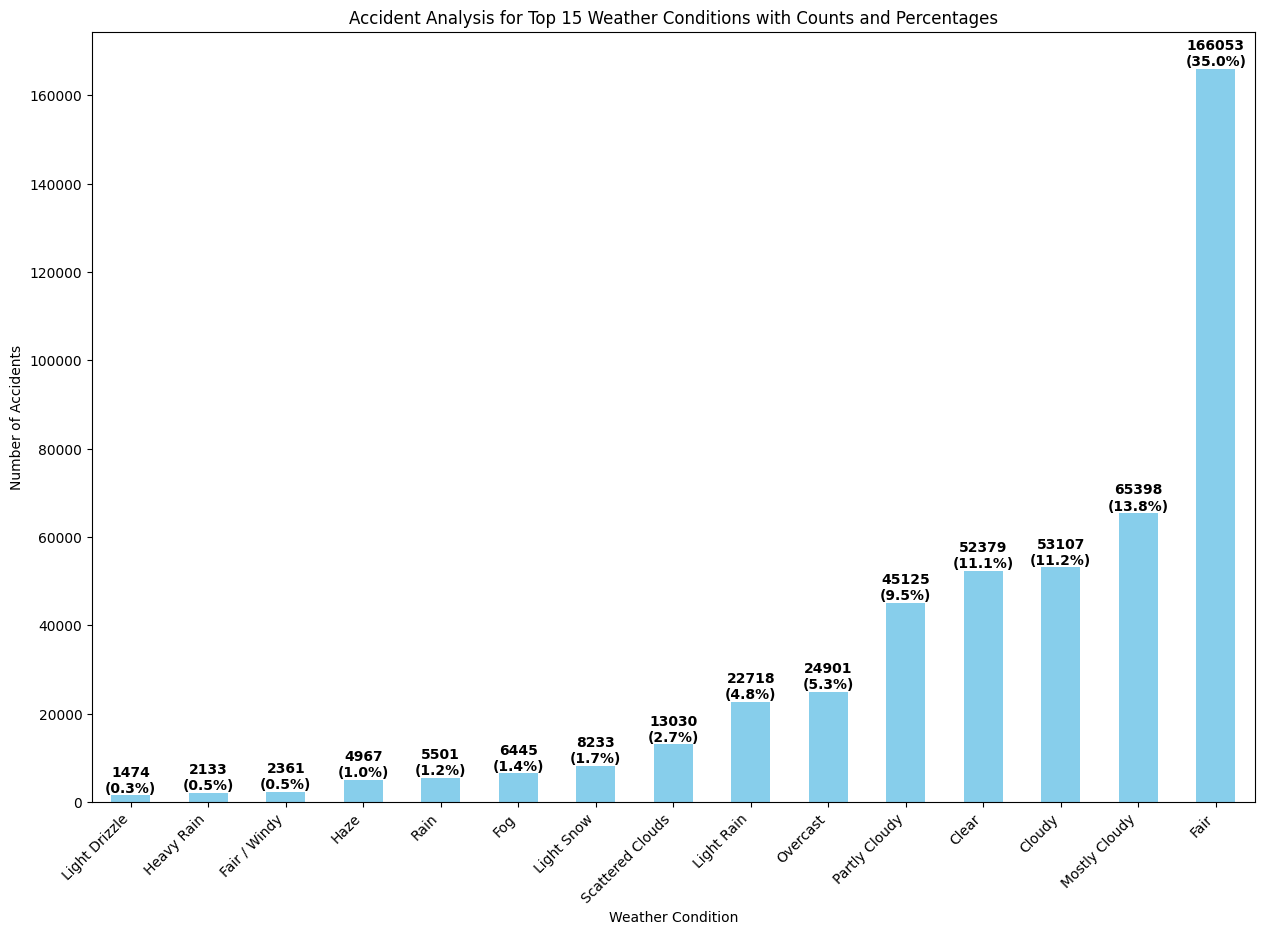

In [27]:
top_weather_conditions = df['Weather_Condition'].value_counts().head(15).index

filtered_data = df[df['Weather_Condition'].isin(top_weather_conditions)]

accident_counts = filtered_data['Weather_Condition'].value_counts()

total_accidents = len(filtered_data)
accident_percentages = (accident_counts / total_accidents) * 100

plt.figure(figsize=(15, 10))
bars = accident_counts.sort_values().plot(kind='bar', color='skyblue')

for bar, percentage in zip(bars.patches, accident_percentages.sort_values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
             f'{int(bar.get_height())}\n({percentage:.1f}%)', ha='center', va='bottom', color='black', fontweight='bold')

plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.title('Accident Analysis for Top 15 Weather Conditions with Counts and Percentages')
plt.xticks(rotation=45, ha='right') 
plt.show()


# **Insights:** 

*  The number of accidents in the United States shows an annual increase from 2016 to 2022 (as full-year data for 2023 is not available). The percentage growth from 2016 to 2017 is 74.45%, from 2017 to 2018 is 23.78%, from 2018 to 2019 is 7.42%, from 2019 to 2020 is 23.12%, from 2020 to 2021 is 33.59%, and from 2021 to 2022 is 11.78%.
*  Miami has consistently ranked highest in terms of road accident occurrences with 12.37% cases of the top 15 city counts, followed by Houston(11.24%) and Los Angeles(10.49%) with very close count.
*  Considering top 15 cities 34.1% of the cases are coming from top 3.
*  Mostly the western and eastern states of US are more prone to road accidents, California(CA) being the most effected state.
*  From 7:00AM to 8:00PM, there is rapid increase in accident cases. This timeframe typically coincides with the commuting hours of working professionals.
*  Among the top 15 weather conditions responsible for road accidents, a majority of incidents occur under fair weather conditions, accounting for 35% of the cases.
*  Alongside, the major area for a large number of cases is in the presence of traffic signal and crossing.
*  Though, on the analysis of the present data it is found that there is lack of accident prevention feature on road like 'Bump', 'Crossing', 'Give_Way', 'Junction', 'Stop', 'No_Exit', 'Traffic_Signal', 'Turning_Loop'. And, even if it is present there is lack of maintenance

# Conclusion:
U.S. faces a concerning annual increase in road accidents, particularly in major cities line Miami, Los Angeles, etc. and states like California. The major reason here is lack of infrastructure and awareness among people.

**To improve the current situation, U.S. can consider implementing the following measures:**
* City-specific Safety Initiatives: Tailor interventions to address the challenges of high-accident cities, focusing on targeted awareness campaigns, law enforcement, and infrastructure improvements.
* Regional Safety Programs: Develop region-specific strategies for states with a higher prevalence of accidents, with major cities and states as a key area of focus, to address the root causes of accidents in these regions.
* Commuter Safety Measures: Implement measures to enhance safety during peak commuting hours, such as increased law enforcement presence, public awareness campaigns, and improved traffic management.
* Weather-Independent Safety Measures: Enhance safety measures that are not dependent on weather conditions, acknowledging that a significant number of accidents occur under fair weather.
* Infrastructure Maintenance: Prioritize the maintenance and repair of accident prevention features, ensuring their functionality and effectiveness in reducing accidents.